In [1]:
from oct2py import octave
import setup
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

octave.addpath("/home/bill/packages/GPML/")
octave.eval("startup")

executing gpml startup script...


0.0

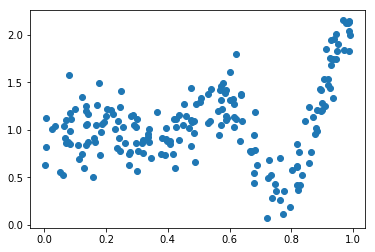

In [49]:
n = 200
x = np.sort(np.random.rand(n))
z = np.linspace(-0.2, 1.2, 100)[:,None]
y = 1 + x*x * np.sin(2 * np.pi * 2.3 * x) + 0.2 * np.random.randn(n)

plt.plot(x, y, 'o');
x = x[:,None]
y = y[:,None]

In [50]:
octave.push("y", y)
octave.push("x", x)
octave.push("z", z)

In [60]:
octave.eval(
"""
a = 1; b = 2;
cov = {@covSEiso}; sf = 0.2; ell = 0.2; hyp.cov = log([ell;sf]);
nu = 5; xu = linspace(0,1,nu)'; covf = {@apxSparse,cov,xu};  % FITC prediction
mean = {@meanSum, {@meanLinear, @meanConst}}; hyp.mean = [a;b];
lik = {@likGauss}; sn = 0.1; hyp.lik = log(sn); inf = @infGaussLik; infv = @(varargin) inf(varargin{:},struct('s',0.9));

[Kuu,   dKuu] = feval(covf{2}{:}, hyp.cov, xu);

tic;
hyp  = minimize(hyp,@gp,-300,inf,mean,cov, lik,x,y);
toc;

tic;
hypf = minimize(hyp,@gp,-300,infv,mean,covf,lik,x,y);
toc;

disp("FULL")
disp("cov hyp:  "); disp(exp(hyp.cov))
disp("mean hyp: "); disp(exp(hyp.mean))
disp("sn:       "); disp(exp(hyp.lik))

disp("");disp("FITC")
disp("cov hyp:  "); disp(exp(hypf.cov))
disp("mean hyp: "); disp(exp(hypf.mean))
disp("sn:       "); disp(exp(hypf.lik))

% full predict
[ymu, ys2] = gp(hyp,inf,mean,cov,lik,x,y,z);

% fitc predict
[ymuf,ys2f] = gp(hyp,inf,mean,covf,lik,x,y,z);
""")

Function evaluation    133;  Value -1.469270e+01
Elapsed time is 5.14036 seconds.
Function evaluation     52;  Value 1.221995e+01
Elapsed time is 1.65618 seconds.
FULL
cov hyp:  
   0.12605
   0.47790
mean hyp: 
   2.2327
   2.0624
sn:       
 0.20447

FITC
cov hyp:  
   0.065145
   0.223048
mean hyp: 
   1.3696
   2.5280
sn:       
 0.18545


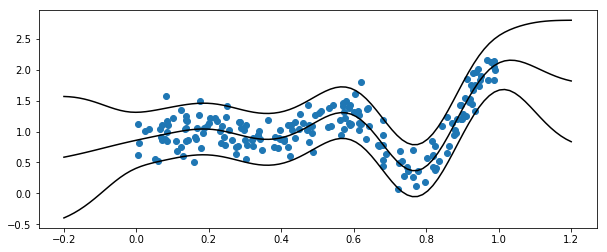

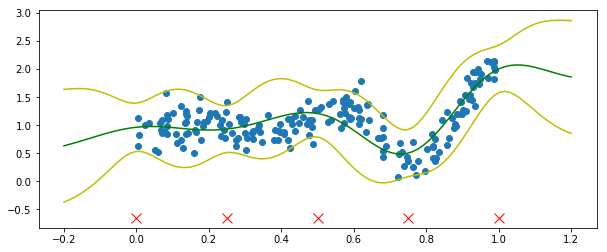

In [61]:
yz   = octave.pull("ymu")
ys2  = octave.pull("ys2")
yzf  = octave.pull("ymuf")
ys2f = octave.pull("ys2f")
xu   = octave.pull("xu")
Kuu  = octave.pull("Kuu")

fig = plt.figure(figsize=(10,4))
plt.plot(x.flatten(), y.flatten(), 'o');
plt.plot(z.flatten(), yz.flatten(), 'k');
plt.plot(z.flatten(), yz.flatten() + 2 * np.sqrt(ys2.flatten()), 'k');
plt.plot(z.flatten(), yz.flatten() - 2 * np.sqrt(ys2.flatten()), 'k');

fig = plt.figure(figsize=(10,4))
plt.plot(x.flatten(), y.flatten(), 'o');
plt.plot(z.flatten(), yzf.flatten(), "g");
plt.plot(z.flatten(), yzf.flatten() + 2 * np.sqrt(ys2f.flatten()), 'y');
plt.plot(z.flatten(), yzf.flatten() - 2 * np.sqrt(ys2f.flatten()), 'y');
plt.plot(xu.flatten(), -0.65 * np.ones(xu.shape[0]), "rx", ms=10);

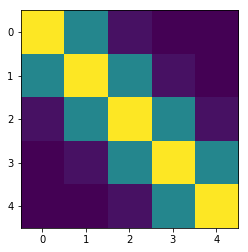

In [63]:
plt.imshow(Kuu);